# Modelos de Baseline sem BOX-COX

## Data

In [12]:
import pandas as pd
from pathlib import Path

path = Path("data_updated.csv")

df = pd.read_csv(path, parse_dates = True)

df["week"] = pd.to_datetime(df["week"])
df.head()

,week,volume,inv,users
0,2022-10-31,0.38,1.609882,6.500
1,2022-11-07,0.47,1.880548,7.061
2,2022-11-14,0.32,2.297810,5.875
3,2022-11-21,1.69,5.623875,24.238
4,2022-11-28,1.23,1.473418,7.648


### Spliting Data

In [18]:
# Célula: criar splits para Time-Series CV (rolling origin / expanding window)
import numpy as np

# parâmetros (ajuste conforme necessário)
initial_train = 120   # tamanho inicial da janela de treino (número de observações)
horizon = 30          # horizonte de previsão por fold
step = 1              # deslocamento entre folds

# garante ordenação temporal
df = df.sort_values("week").reset_index(drop=True)
series = df["volume"].astype(float).reset_index(drop=True)
n = len(series)

if initial_train + horizon > n:
    raise ValueError(f"Parâmetros inválidos: initial_train + horizon = {initial_train + horizon} > n ({n}). Reduza valores.")

# gera splits: cada item é (train_slice, test_slice) com slices python [start:stop)
cv_splits = []
for train_end in range(initial_train, n - horizon + 1, step):
    train_slice = slice(0, train_end)                       # treino: [0, train_end)
    test_slice = slice(train_end, train_end + horizon)      # teste: [train_end, train_end+horizon)
    cv_splits.append((train_slice, test_slice))

# resumo
print(f"Observações totais: {n}")
print(f"Folds gerados: {len(cv_splits)} (initial_train={initial_train}, horizon={horizon}, step={step})")
print("Exemplo dos 3 primeiros folds (indices start:stop):")
for i, (tr, te) in enumerate(cv_splits[:3], 1):
    print(f" Fold {i}: train {tr.start}:{tr.stop} -> test {te.start}:{te.stop}")


Observações totais: 157
Folds gerados: 8 (initial_train=120, horizon=30, step=1)
Exemplo dos 3 primeiros folds (indices start:stop):
 Fold 1: train 0:120 -> test 120:150
 Fold 2: train 0:121 -> test 121:151
 Fold 3: train 0:122 -> test 122:152


### Método da Média (Mean Method)

Este método assume que a melhor previsão para o futuro é simplesmente a média dos valores históricos observados até o momento. A previsão para $h$ períodos à frente ($T+h$) é dada por:

$\hat{y}_{T+h|T} = \bar{y} = \frac{y_1 + ... + y_T}{T}$

Onde:
- $\hat{y}_{T+h|T}$ é a previsão para o período $T+h$, feita no tempo $T$.
- $\bar{y}$ é a média dos valores observados até o tempo $T$.
- $y_i$ é o valor observado no tempo $i$.
- $T$ é o número total de observações históricas.

Este método é eficaz quando a série temporal não apresenta uma tendência clara ou sazonalidade, e os valores futuros são esperados em torno da média histórica. É o baseline mais simples e serve para verificar se qualquer modelo mais complexo consegue superar a simples média histórica.

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

rows = []
for i, (tr_slice, te_slice) in enumerate(cv_splits, start=1):
    train = series.iloc[tr_slice].reset_index(drop=True)
    test = series.iloc[te_slice].reset_index(drop=True)
    h = len(test)
    mu = train.mean()
    preds = np.repeat(mu, h)
    mae = mean_absolute_error(test, preds)
    rmse = np.sqrt(mean_squared_error(test, preds))
    denom = np.where(np.abs(test.values) < 1e-9, 1e-9, test.values)
    mape = np.mean(np.abs((test.values - preds) / denom)) * 100
    rows.append({
        "fold": i,
        "train_end_index": tr_slice.stop - 1,
        "train_size": len(train),
        "horizon": h,
        "mean_train": mu,
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": mape
    })

res_mean = pd.DataFrame(rows)
# res_mean.to_csv("baseline_mean_folds.csv", index=False)
res_mean

,fold,train_end_index,train_size,horizon,mean_train,MAE,RMSE,MAPE
0,1,119,120,30,2.526833,7.963500,8.433096,74.248435
1,2,120,121,30,2.559339,8.427994,9.049198,74.838561
2,3,121,122,30,2.600984,8.792350,9.498659,75.126517
3,4,122,123,30,2.653821,9.113846,9.916047,75.158198
4,5,123,124,30,2.711613,9.212054,10.011284,74.914302
5,6,124,125,30,2.739360,9.574640,10.342734,75.624740
6,7,125,126,30,2.778571,10.096762,11.008104,76.104079
7,8,126,127,30,2.822126,10.457541,11.386094,76.401298


In [29]:
# agregados
agg = res_mean.agg({
    "MAE": ["mean","std"],
    "RMSE": ["mean","std"],
    "MAPE": ["mean","std"]
}).T
print("Resumo agregado (Mean Method):")
display(agg)

print("\nLinhas por fold:")
display(res_mean)


Resumo agregado (Mean Method):


,mean,std
MAE,9.204836,0.830183
RMSE,9.955652,0.975192
MAPE,75.302016,0.705338



Linhas por fold:


,fold,train_end_index,train_size,horizon,mean_train,MAE,RMSE,MAPE
0,1,119,120,30,2.526833,7.963500,8.433096,74.248435
1,2,120,121,30,2.559339,8.427994,9.049198,74.838561
2,3,121,122,30,2.600984,8.792350,9.498659,75.126517
3,4,122,123,30,2.653821,9.113846,9.916047,75.158198
4,5,123,124,30,2.711613,9.212054,10.011284,74.914302
5,6,124,125,30,2.739360,9.574640,10.342734,75.624740
6,7,125,126,30,2.778571,10.096762,11.008104,76.104079
7,8,126,127,30,2.822126,10.457541,11.386094,76.401298


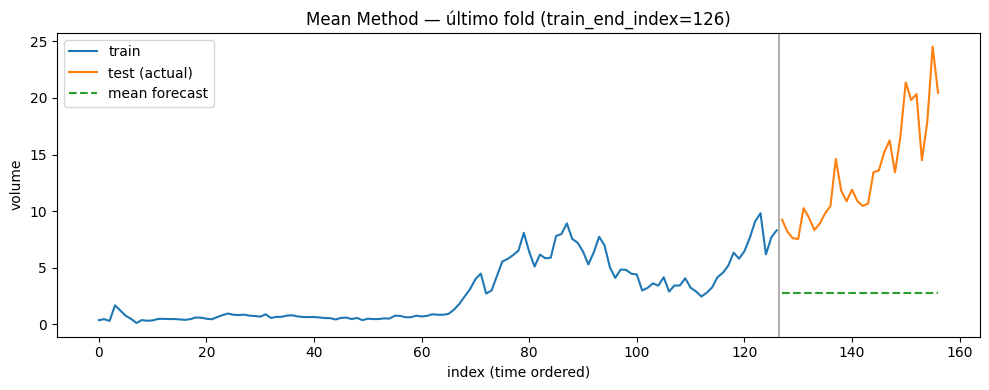

In [26]:
# Plot do último fold (visualização treino/teste/pred)
last = cv_splits[-1]
train = series.iloc[last[0]].reset_index(drop=True)
test = series.iloc[last[1]].reset_index(drop=True)
h = len(test)
preds = np.repeat(train.mean(), h)

plt.figure(figsize=(10,4))
plt.plot(np.arange(len(train)), train, label="train", color="C0")
plt.plot(np.arange(len(train), len(train)+h), test, label="test (actual)", color="C1")
plt.plot(np.arange(len(train), len(train)+h), preds, label="mean forecast", color="C2", linestyle="--")
plt.axvline(len(train)-0.5, color="k", alpha=0.3)
plt.legend()
plt.title(f"Mean Method — último fold (train_end_index={last[0].stop-1})")
plt.xlabel("index (time ordered)")
plt.ylabel("volume")
plt.tight_layout()
plt.show()

In [30]:
# agregados
agg = res_mean.agg({
    "MAE": ["mean","std"],
    "RMSE": ["mean","std"],
    "MAPE": ["mean","std"]
}).T
print("Resumo agregado (Mean Method):")
display(agg)


Resumo agregado (Mean Method):


,mean,std
MAE,9.204836,0.830183
RMSE,9.955652,0.975192
MAPE,75.302016,0.705338


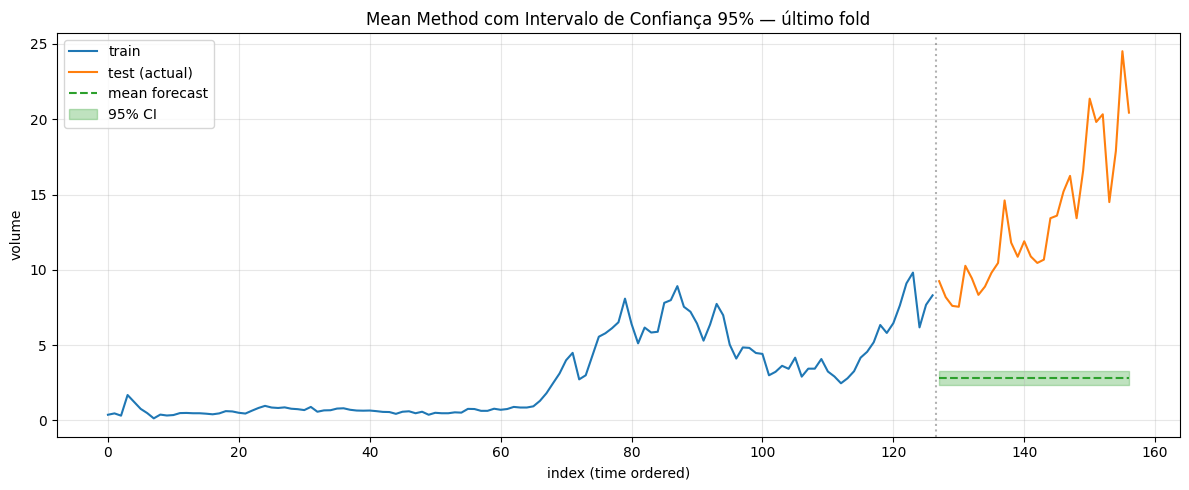

Intervalo de Confiança (95%):
  Previsão pontual: 2.82
  Desvio padrão residual (treino): 2.67
  Margem de erro: ±0.46
  Intervalo: [2.36, 3.29]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# último fold
last = cv_splits[-1]
train = series.iloc[last[0]].reset_index(drop=True)
test = series.iloc[last[1]].reset_index(drop=True)
h = len(test)

# previsão pontual (média)
mu = train.mean()
preds = np.repeat(mu, h)

# intervalo de confiança: baseado no desvio padrão dos resíduos do treino
# resíduos = valores reais - valor médio
residuals = train - mu
std_residuals = np.std(residuals, ddof=1)  # desvio padrão amostral

# margem de erro (95% de confiança) = z_score * std_residuals / sqrt(n)
z_score = stats.norm.ppf(0.975)  # 1.96 para 95%
margin_of_error = z_score * std_residuals / np.sqrt(len(train))

# limites do intervalo
lower = preds - margin_of_error
upper = preds + margin_of_error

# plot
fig, ax = plt.subplots(figsize=(12, 5))

# treino
train_idx = np.arange(len(train))
ax.plot(train_idx, train, label="train", color="C0", linewidth=1.5)

# teste + previsão + intervalo
test_idx = np.arange(len(train), len(train) + h)
ax.plot(test_idx, test, label="test (actual)", color="C1", linewidth=1.5)
ax.plot(test_idx, preds, label="mean forecast", color="C2", linestyle="--", linewidth=1.5)
ax.fill_between(test_idx, lower, upper, alpha=0.3, color="C2", label="95% CI")

# separador treino/teste
ax.axvline(len(train) - 0.5, color="k", alpha=0.3, linestyle=":")

ax.legend()
ax.set_title(f"Mean Method com Intervalo de Confiança 95% — último fold")
ax.set_xlabel("index (time ordered)")
ax.set_ylabel("volume")
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Intervalo de Confiança (95%):")
print(f"  Previsão pontual: {mu:.2f}")
print(f"  Desvio padrão residual (treino): {std_residuals:.2f}")
print(f"  Margem de erro: ±{margin_of_error:.2f}")
print(f"  Intervalo: [{lower[0]:.2f}, {upper[0]:.2f}]")
# ...existing code...

In [34]:
import numpy as np

alpha = 0.05  # nível de significância (IC 95%)

# cobertura e taxa de violação
coverage = np.sum((test >= lower) & (test <= upper)) / len(test) * 100
violation_rate = 100 - coverage

# largura média do intervalo
avg_width = np.mean(upper - lower)
train_range = train.max() - train.min()
pinaw = avg_width / train_range * 100

# Winkler Score (penaliza largura + violações)
# Fórmula: 
#   se y_t in [L_t, U_t]: W_t = U_t - L_t
#   se y_t < L_t:         W_t = U_t - L_t + 2/alpha * (L_t - y_t)
#   se y_t > U_t:         W_t = U_t - L_t + 2/alpha * (y_t - U_t)

winkler_scores = []
for i, y_t in enumerate(test):
    width = upper[i] - lower[i]
    if y_t < lower[i]:
        ws = width + (2 / alpha) * (lower[i] - y_t)
    elif y_t > upper[i]:
        ws = width + (2 / alpha) * (y_t - upper[i])
    else:
        ws = width
    winkler_scores.append(ws)

mean_winkler = np.mean(winkler_scores)

print("=" * 60)
print("MÉTRICAS DO INTERVALO DE CONFIANÇA (95%)")
print("=" * 60)
print(f"\n1. Cobertura (Coverage):")
print(f"   {coverage:.2f}% (ideal: ~95%)")

print(f"\n2. Taxa de Violação:")
print(f"   {violation_rate:.2f}% (ideal: ~5%)")

print(f"\n3. Largura média do intervalo:")
print(f"   {avg_width:.4f}")

print(f"\n4. PINAW (normalizado pelo range de treino):")
print(f"   {pinaw:.2f}% (menor = intervalo mais estreito)")

print(f"\n5. Winkler Score (média):")
print(f"   {mean_winkler:.4f}")
print(f"   (Menor é melhor: combina largura + penalidade por violações)")


MÉTRICAS DO INTERVALO DE CONFIANÇA (95%)

1. Cobertura (Coverage):
   0.00% (ideal: ~95%)

2. Taxa de Violação:
   100.00% (ideal: ~5%)

3. Largura média do intervalo:
   0.9270

4. PINAW (normalizado pelo range de treino):
   9.58% (menor = intervalo mais estreito)

5. Winkler Score (média):
   400.6885
   (Menor é melhor: combina largura + penalidade por violações)


### Método Ingênuo ou Passeio Aleatório sem Tendência (Naive or Random Walk with No Drift)

Neste método, a previsão para o próximo período é simplesmente o último valor observado. Este método é conhecido como “ingênuo” porque assume que as mudanças futuras serão iguais às últimas observações, ou seja, que não temos nenhum insight sistemático sobre os valores futuros além do valor mais recente. A previsão para $h$ períodos à frente é dada por:

$\hat{y}_{T+h|T} = y_T$

Onde:
- $\hat{y}_{T+h|T}$ é a previsão para o período $T+h$, feita no tempo $T$.
- $y_T$ é o último valor observado no tempo $T$.

Este baseline é muito útil para séries que se assemelham a um passeio aleatório. Se um modelo não consegue superar o método ingênuo, isso pode indicar que a série é muito volátil ou que o modelo não está capturando adequadamente a estrutura de dependência temporal de curto prazo.

### Método Sazonal Ingênuo (Seasonal Naive)

Este método é uma variação do método ingênuo, especialmente útil para séries com forte sazonalidade conhecida. Ele prevê o valor para um período futuro usando o valor observado no mesmo período sazonal do ciclo anterior.

A previsão para o período $T+h$ é dada por:

$\hat{y}_{T+h|T} = y_{T+h-m}$

Onde:
- $\hat{y}_{T+h|T}$ é a previsão para o período $T+h$, feita no tempo $T$.
- $y_{T+h-m}$ é o valor observado no mesmo período sazonal ($m$) do ciclo anterior mais recente disponível nos dados históricos.
- $m$ é o período da sazonalidade (por exemplo, $m=12$ para dados mensais com sazonalidade anual, $m=52$ para dados semanais com sazonalidade anual).

Este baseline é um forte concorrente para séries com padrões sazonais consistentes. Se um modelo não superar o Seasonal Naive para uma série sazonal, ele pode não estar capturando bem o componente sazonal.

### Método do Desvio (Drift Method)

O método do desvio é utilizado para séries temporais que seguem uma tendência linear ao longo do tempo. Este método assume que a diferença média entre observações consecutivas é constante, resultando em uma previsão que extrapola essa tendência:

$y_t = C + y_{t−1} + \epsilon_t$

A previsão para $h$ períodos à frente é dada por:

$\hat{y}_{T+h|T} = y_T + h \cdot C$

Onde $C$ representa o desvio médio entre as observações no período de treino:

$C = \frac{\sum_{t=2}^T (y_t − y_{t−1})}{T − 1} = \frac{y_T − y_1}{T − 1}$

Portanto, a previsão pode ser reescrita como:

$\hat{y}_{T+h|T} = y_T + h \left( \frac{y_T − y_1}{T − 1} \right)$

Este método é útil para séries que apresentam uma tendência consistente ao longo do tempo, como crescimento linear. Ele é mais robusto que o Método Ingênuo para séries com tendência, pois incorpora essa inclinação média na previsão.

### Método da Média Móvel (Rolling Mean)

O método da média móvel utiliza a média dos últimos $K$ valores observados como previsão para o futuro. Ele suaviza as flutuações de curto prazo e pode capturar tendências locais, mas não lida bem com sazonalidade forte ou tendências de longo prazo.

A previsão para $h$ períodos à frente é dada por:

$\hat{y}_{T+h|T} = \frac{y_{T} + y_{T-1} + ... + y_{T-K+1}}{K}$

Onde:
- $\hat{y}_{T+h|T}$ é a previsão para o período $T+h$, feita no tempo $T$.
- $y_i$ são os valores observados.
- $K$ é o número de períodos usados para calcular a média móvel.

Este baseline é mais reativo a mudanças recentes na série do que o Método da Média simples. O parâmetro $K$ pode ser ajustado; um $K$ menor torna a previsão mais responsiva a mudanças recentes, enquanto um $K$ maior a torna mais suave.